In [1]:
# !pip install datasets
# !pip install torchmetrics
# !pip install pytz
# !pip install persiantools
# !pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 46.8 MB/s 
     |████████████████████████████████| 163 kB 63.5 MB/s 
     |████████████████████████████████| 115 kB 55.6 MB/s 
     |████████████████████████████████| 95 kB 5.7 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
     |████████████████████████████████| 115 kB 47.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/si

# Mount Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# %cd /content/drive/MyDrive

/content/drive/MyDrive


# Configuration

In [4]:
config = {}
config['root_path'] = '/home/user01/'
config['series_ID'] = 103
config['series_desc'] = '''
targeted backdoor attack labels changed - LR influence attack manually implemented (without the help of jax)
'''
config['log_path'] = config['root_path']+'experiments/MNIST/SVM/'
config['log'] = {}

In [5]:
config['poisoning_rate'] = 0.2
# config['num_clean_examples'] = 200
config['learning_rate'] = 0.01
config['batch_size'] = 32
config['num_epochs'] = 2
config['attack_step_size'] = 0.1
config['num_iters'] = 1000

In [6]:
config['log']['model'] = 'SVM'
config['log']['dataset'] = 'MNIST (0-1)'
config['log']['task'] = 'binary classification'
config['log']['pytorch_seed'] = 50
config['log']['numpy_seed'] = 50
config['log']['projection'] = 'R^400'
config['log']['attack'] = 'influence'
config['log']['method'] = 'add'

In [7]:
config['log_path'] += (str(config['series_ID']) + '-' + config['log']['attack'] + '-' + config['log']['dataset'] + '-' + str(int(config['poisoning_rate']*100)) + '-' + config['log']['method'] + '.json').lower().replace(' ', '')

In [8]:
config['log_path']

'/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-20-add.json'

In [9]:
### WE NEED THIS TO IMPORT THE NECESSARY LIBRARIES ###
import sys
sys.path.append(config['root_path'])

In [10]:
import datascience, poisoning, report
from datascience.data import CIFAR10, MNIST, IMDB, BOSTON
from datascience.general import train_dev_test_split, join_np_arrays, describe_dataset, randomized_round
from poisoning.process import attacker, defender, SVM_influence_attacker, LR_influence_attacker
from poisoning.eval import attack_success_rate, benign_accuracy, test_accuracy
from report.log import JSONLogger, TextLogger, tehran_datetime
from temporary.functions import _reload
import numpy as np
import torch
from torchmetrics import HingeLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad
from torch.nn.utils import _stateless
from datetime import datetime
import pytz
from persiantools.jdatetime import JalaliDate
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [11]:
_reload(poisoning.process)
_reload(poisoning.eval)
_reload(datascience.data)
_reload(datascience.general)
_reload(report.log)

<module 'report.log' from '/content/drive/MyDrive/report/log.py'>

In [12]:
torch.manual_seed(config['log']['pytorch_seed'])

# Loading a Dataset

In [13]:
dataset = MNIST()
dataset.select_labels([0,1], phase='train')
dataset.select_labels([0,1], phase='test')
dataset.resize(20,20)
dataset.flatten()
dataset.rescale()
dataset.random_sample(2000, 'train')
dataset.random_sample(200, 'test')

11490434/11490434 [==============================] - 0s 0us/step


In [14]:
dataset.change_labels({0:-1})

In [15]:
# dataset.separate_examples(config['num_clean_examples'], desired_seed = config['log']['numpy_seed'])

# Attack

In [16]:
att = SVM_influence_attacker(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test, config['poisoning_rate'], config['attack_step_size'], config['log']['method'])

In [17]:
%%time
att.attack(num_iters=config['num_iters'])

 iteration 999 CPU times: user 5min 26s, sys: 4min 10s, total: 9min 36s
Wall time: 5min


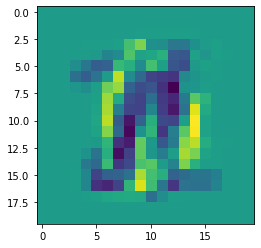

In [24]:
from matplotlib import pyplot as plt
plt.imshow(att.x_poison[-100].reshape((20,20)))

In [ ]:
result = att.return_aggregated_result()

In [ ]:
result['y_train'] = np.array([1 if _y==1 else 0 for _y in result['y_train']])
dataset.revert_labels()

In [ ]:
config['data-train'] = describe_dataset(result['x_train'], result['y_train'], 'training dataset')

In [ ]:
config['data-test'] = describe_dataset(dataset.x_test, dataset.y_test, 'testing dataset')

# Prepare the Data

In [ ]:
class MyVectorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = np.array(labels).reshape(-1, 1)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.features[idx]).to(device), torch.Tensor(self.labels[idx]).to(device)

In [ ]:
train_dataset = MyVectorDataset(result['x_train'], result['y_train'])
# train_dataset = MyVectorDataset(dataset.x_train, dataset.y_train)
test_dataset = MyVectorDataset(dataset.x_test, dataset.y_test)
# clean_dataset = MyVectorDataset(dataset.x_train_clean, dataset.y_train_clean)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)
# clean_dataloader = DataLoader(clean_dataset, batch_size=config['batch_size'], shuffle=True)

# Train a Model

In [ ]:
class SVM(torch.nn.Module):
    def __init__(self):
        super(SVM, self).__init__() 
        self.linear = torch.nn.Linear(in_features=400, out_features=1, bias=True)
    def forward(self, x):
        output = self.linear(x)
        return output

In [ ]:
model = SVM()
model = model.to(device)
loss_fn = HingeLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)

In [ ]:
def output_to_label(out):
    if out >= 0:
      return 1
    else:
      return 0

In [ ]:
def make_prediction(model, x_arr):
  outs = list(model(torch.Tensor(x_arr)).squeeze().detach().numpy())
  labels = [output_to_label(out) for out in outs]
  return np.array(labels)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_num):
    num_points = len(dataloader.dataset)
    for batch, (features, labels) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(features)
        loss = loss_fn(pred, labels)
        
        # Backpropagation
        optimizer.zero_grad() # sets gradients of all model parameters to zero
        loss.backward() # calculate the gradients again
        optimizer.step() # w = w - learning_rate * grad(loss)_with_respect_to_w

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"\r Epoch {epoch_num} - loss: {loss:>7f}  [{current:>5d}/{num_points:>5d}]", end=" ")

In [ ]:
def test_loop(dataloader, model, loss_fn, epoch_num, name):
    num_points = len(dataloader.dataset)
    sum_test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (features, labels) in enumerate(dataloader):
            pred = model(features)
            sum_test_loss += loss_fn(pred, labels).item() # add the current loss to the sum of the losses
            # convert the outputs of the model on the current batch to a numpy array
            pred_lst = list(pred.cpu().numpy().squeeze())
            pred_lst = [output_to_label(item) for item in pred_lst]
            # convert the original labels corresponding to the current batch to a numpy array
            output_lst = list(labels.cpu().numpy().squeeze()) 
            # determine the points for which the model is correctly predicting the label (add a 1 for each)
            match_lst = [1 if p==o else 0 for (p, o) in zip(pred_lst, output_lst)] 
            # count how many points are labeled correctly in this batch and add the number to the overall count of the correct labeled points
            correct += sum(match_lst) 
            
    sum_test_loss /= num_points
    correct /= num_points
    config['log']['accuracy_'+name] = (100*correct)
    config['log']['loss_'+name] = sum_test_loss
    print(f"\r Epoch {epoch_num} - {name} Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {sum_test_loss:>8f}", end=" ")

In [ ]:
for epoch_num in range(1, config['num_epochs']+1):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num)

In [ ]:
test_loop(train_dataloader, model, loss_fn, config['num_epochs'], 'Train')

In [ ]:
test_loop(test_dataloader, model, loss_fn, config['num_epochs'], 'Test')

In [ ]:
y_train_pred = make_prediction(model, result['x_train'])
y_test_pred = make_prediction(model, dataset.x_test)

In [ ]:
config['log']['benign_accuracy'] = benign_accuracy(result['y_train'], y_train_pred, result['is_poison'])
config['log']['attack_success_rate'] = attack_success_rate(result['y_train'], y_train_pred, result['is_poison'])

In [ ]:
config['datetime'] = tehran_datetime()

In [ ]:
config

In [ ]:
logger = JSONLogger(config['log_path'], config)
logger.log()